In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc

<h2>CNN-4 Model</h2>

Tradeoff between getting High performing model and trying to keep it as 'natural' as possible to make analysis later easier.

In [14]:
class CNN4(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.num_conv = 32
        self.conv_layers = nn.Sequential(
         nn.Conv2d(1,self.num_conv, kernel_size=3, stride=1, padding=1, bias = False),
         nn.MaxPool2d(2,2),
         nn.Conv2d(self.num_conv,self.num_conv, kernel_size=3, stride=1, padding=1, bias = False),
         nn.Conv2d(self.num_conv,self.num_conv, kernel_size=3, stride=1, padding=1, bias = False),
         nn.MaxPool2d(2,2),
         nn.Conv2d(self.num_conv,self.num_conv, kernel_size=3, stride=1, padding=1, bias = False),
        )
        # 28 * 28 (Image) * num_conv * (0.5^(number of max pools*n_dim))
        self.final_image_size = 7 * 7 * self.num_conv 
        self.fc1 = nn.Linear(self.final_image_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.final_image_size) 
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        return x 

In [15]:
BATCH_SIZE = 32
t = torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize(mean=(0), std=(1))]
                       ) 
train_data = torchvision.datasets.MNIST('/data/mnist', download=True, train=True, transform=t)
#Can be used to speed up training 
#train_data_sub = torch.utils.data.Subset(train_data, range(0,128))
train_loader = torch.utils.data.DataLoader( train_data, 
                batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('/data/mnist', download=True, train=False, transform=t), 
                batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

<h2>Training</h2>

In [16]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [17]:
LEARNING_RATE = 1e-4
device = torch.device("cuda:0")
loss_fn = nn.CrossEntropyLoss()

def training_loop(model, n_epochs, data_loader):
    optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
    model.train()
    training_loss = []
    for epoch in range(n_epochs): 
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            # print statistics
            running_loss += loss.item()
        training_loss.append(running_loss/len(data_loader))
    
    print('Finished Training')
    return training_loss

def model_eval(model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return 100 * correct // total

<h2>Changing labels</h2>

In [18]:
# noise = 0.99 #Roughly 100 noisy labels for every one 'good label'
def generate_noise(noise=0.99):
  noise_labels = np.array(train_data.targets)
  for (i, label) in enumerate(noise_labels):
    if(np.random.uniform() < noise):
      noise_labels[i] = np.round(np.random.uniform(0, 9.0))
  
  noise_labels = torch.from_numpy(noise_labels)
  
  train_data_noise = torchvision.datasets.MNIST('/data/mnist', download=True, train=True, transform=t)
  train_data_noise.targets = noise_labels
  train_loader_noise = torch.utils.data.DataLoader( train_data_noise, 
                  batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
  
  print(train_data.targets)
  print(train_data_noise.targets)
  return train_loader_noise

<h1>Experiment</h1>


Finished Training
Accuracy of the network on the 10000 test images: 98 %


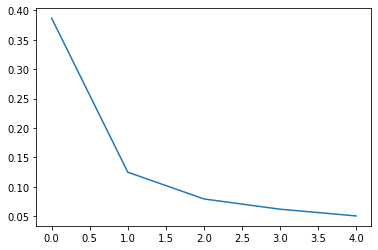

In [19]:
model = CNN4().to(device)
training_loss = training_loop(model, 5, train_loader) #Model is updated inplace
model_eval(model)
plt.plot(training_loss)

perhaps longer training time is the trick here ?

In [20]:
noise = [0.1, 0.5, 0.99]
accuracy = []
noise_training_loss_arr = []
for n in noise:
  model_noise = CNN4().to(device)
  noise_training_loss = training_loop(model_noise, 5, generate_noise(n))
  noise_training_loss_arr.append(noise_training_loss)
  accuracy.append(model_eval(model_noise))

tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([5, 0, 4,  ..., 5, 6, 8])
Finished Training
Accuracy of the network on the 10000 test images: 98 %
tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([5, 0, 5,  ..., 5, 6, 5])
Finished Training
Accuracy of the network on the 10000 test images: 97 %
tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([5, 9, 8,  ..., 7, 2, 5])
Finished Training
Accuracy of the network on the 10000 test images: 25 %


In [21]:
accuracy

[98, 97, 25]

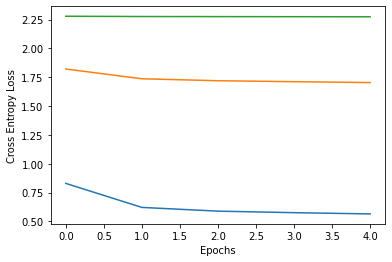

In [23]:
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
for x in noise_training_loss_arr:
  plt.plot(x)

One training run is enough to get good test score accuracy, however training loss is still high. I guess it knows the right answer after a single epoch but it is still unsure?